# Stock Price Prediction

Let's say we want to make money by buying stocks. Since we want to make money, we only want to buy stock on days when the price will go up (we're against shorting the stock). We'll create a machine learning algorithm to predict if the stock price will increase tomorrow. If the algorithm says that the price will increase, we'll buy stock. If the algorithm says that the price will go down, we won't do anything.

We want to maximize our *true positives* - days when the algorithm predicts that the price will go up, and it actually goes go up. Therefore, we'll be using precision as our error metric for our algorithm, which is *true positives / (false positives + true positives)*. This will ensure that we minimize how much money we lose with *false positives* (days when we buy the stock, but the price actually goes down).

This means that we will have to accept a lot of false negatives - days when we predict that the price will go down, but it actually goes up. This is okay, since we'd rather minimize our potential losses than maximize our potential gains.

## Method

Before we get to the machine learning, we need to do a lot of work to acquire and clean up the data. Here are the steps we'll follow:

- Download historical stock prices from Yahoo finance
- Explore the data
- Setup the dataset to predict future prices using historical prices
- Test a machine learning model
- Setup a backtesting engine
- Improve the accuracy of the model

## Downloading the data

In [37]:
# Import finance API and get historical stock
import yfinance as yf
import os 
import json
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already download
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period = "max")
    # Save file to json in case we need it later
    msft_hist.to_json(DATA_PATH)


As we can see, we have one row of data for each day that Microsoft stock was traded. Here are the columns:

- Open - the price the stock opened at.
- High - the highest price during the day
- Low - the lowest price during the day
- Close - the closing price on the trading day
- Volume - how many shares were traded
  
Stock doesn't trade every day (there is no trading on weekends and holidays), so some dates are missing

In [38]:
# Display microsoft stock price history so we can look at the structure of the data
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,0.055653,0.063838,0.055653,0.061109,1031788800,0.0,0.0
1986-03-14,0.061109,0.064383,0.061109,0.063292,308160000,0.0,0.0
1986-03-17,0.063292,0.064929,0.063292,0.064383,133171200,0.0,0.0
1986-03-18,0.064383,0.064929,0.062201,0.062746,67766400,0.0,0.0
1986-03-19,0.062746,0.063292,0.061109,0.061655,47894400,0.0,0.0


Next, we'll plot the data so we can see how the stock price has changed over time. This gives us another overview of the structure of the data.

<AxesSubplot:>

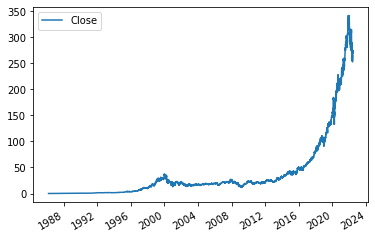

In [39]:
msft_hist.plot.line(y="Close", use_index=True)

 ## Preparing the data

 Ok, hopefully you've stopped kicking yourself for not buying Microsoft stock at any point in the past 30 years now.

Now, let's prepare the data so we can make predictions. We'll be predicting if the price will go up or down tomorrow based on data from today.

First, we'll identify a target that we're trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be *1* and if it went down, the target will be *0*.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions! (a very common mistake)

Then, we'll combine both so we have our training data.

In [40]:
# Ensure we know the actual closing price
data = msft_hist[['Close']]
data = data.rename(columns={'Close':'Actual_Close'})
# Setup our target.  This identifies if the price went up or dow
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1]> x.iloc[0])["Close"]

In [41]:
data.head()

,Actual_Close,Target
1986-03-13,0.061109,NaN
1986-03-14,0.063292,1.0
1986-03-17,0.064383,1.0
1986-03-18,0.062746,0.0
1986-03-19,0.061655,0.0


In [42]:
# Shift stock prices forward one day, so we're predicting tomorr
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055653,0.063838,0.055653,0.061109,1.031789e+09,0.0,0.0
1986-03-17,0.061109,0.064383,0.061109,0.063292,3.081600e+08,0.0,0.0
1986-03-18,0.063292,0.064929,0.063292,0.064383,1.331712e+08,0.0,0.0
1986-03-19,0.064383,0.064929,0.062201,0.062746,6.776640e+07,0.0,0.0


In [43]:
# Create our training data
predictors = ["Close","High","Low","Open","Volume"]
data = data.join(msft_prev[predictors]).iloc[1:]
data.head()

,Actual_Close,Target,Close,High,Low,Open,Volume
1986-03-14,0.063292,1.0,0.061109,0.063838,0.055653,0.055653,1.031789e+09
1986-03-17,0.064383,1.0,0.063292,0.064383,0.061109,0.061109,3.081600e+08
1986-03-18,0.062746,0.0,0.064383,0.064929,0.063292,0.063292,1.331712e+08
1986-03-19,0.061655,0.0,0.062746,0.064929,0.062201,0.064383,6.776640e+07
1986-03-20,0.060018,0.0,0.061655,0.063292,0.061109,0.062746,4.789440e+07


## Training machine learning model

In [44]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100,min_samples_split=200, random_state=1)

train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors],train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [45]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index= test.index)
preds

2022-01-13    1.0
2022-01-14    1.0
2022-01-18    1.0
2022-01-19    1.0
2022-01-20    1.0
             ... 
2022-06-01    1.0
2022-06-02    1.0
2022-06-03    1.0
2022-06-06    1.0
2022-06-07    1.0
Length: 100, dtype: float64

In [46]:
preds.value_counts()

1.0    97
0.0     3
dtype: int64

In [47]:
precision_score(test["Target"], preds)

0.4742268041237113

In [48]:
combined = pd.concat({"Target": test["Target"],"Prediction":preds}, axis=1)
combined.head()

,Target,Prediction
2022-01-13,0.0,1.0
2022-01-14,1.0,1.0
2022-01-18,0.0,1.0
2022-01-19,1.0,1.0
2022-01-20,0.0,1.0


<AxesSubplot:>

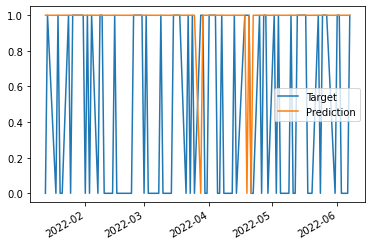

In [49]:
combined.plot()

## Create a Backtesting Engine

In [57]:
start = 1000
step = 750

def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    for i in range(start,data.shape[0],step):

        train = data.iloc[:i].copy()
        test = data.iloc[i:(i+step)].copy()

        model.fit(train[predictors],train["Target"])
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds <= .6] = 0

        combined = pd.concat({"Target":test["Target"],"Predictions":preds}, axis=1)
        predictions.append(combined)
 
    predictions = pd.concat(predictions)
    return predictions

#predictions["Predictions"].value_counts()


0.0    7442
1.0     691
Name: Predictions, dtype: int64

## Improving the accuracy of the model

In [53]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5065123010130246

In [54]:
weekly_mean = data.rolling(7).mean()
quaterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

weekly_trend = data.shift(1).rolling(7).mean()["Target"]


In [55]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quaterly_mean"] = quaterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quaterly_mean"]
data["weekly_trend"] = data["annual_mean"] / data["weekly_mean"]

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean","quaterly_mean","annual_mean","annual_weekly_mean","annual_quarterly_mean","weekly_trend","open_close_ratio","high_close_ratio","low_close_ratio"]

In [58]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [59]:
precision_score(predictions["Target"],predictions["Predictions"])

0.554140127388535

In [60]:
predictions["Predictions"].value_counts()

0.0    7454
1.0     314
Name: Predictions, dtype: int64